# 2편-(2). 불순도 기반 Feature Importance는 진짜 연속형 변수를 선호할까?

## 1. 전처리 과정

In [2]:
%matplotlib notebook
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings(action='ignore')

data=pd.read_csv('C:/data/통머 project/adult_census_income.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### (1) 결측치 처리

In [3]:
data[data=='?']=np.nan
data.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [4]:
# workclass 결측치인 행 모두 제거
index = data['workclass'].isnull()
df=data[-index]
df.isnull().sum()

age                 0
workclass           0
fnlwgt              0
education           0
education.num       0
marital.status      0
occupation          7
relationship        0
race                0
sex                 0
capital.gain        0
capital.loss        0
hours.per.week      0
native.country    556
income              0
dtype: int64

In [5]:
# occupation 결측치인 행은 'Unemployed'로 대체
df=df.fillna({'occupation':'Unemployed'})
df.isnull().sum()

age                 0
workclass           0
fnlwgt              0
education           0
education.num       0
marital.status      0
occupation          0
relationship        0
race                0
sex                 0
capital.gain        0
capital.loss        0
hours.per.week      0
native.country    556
income              0
dtype: int64

In [6]:
#native.country 결측치 처리 전 범주를 'US'와 'not-US'로 구분.
def change_country(x):
    if x=='United-States': 
        return 'US'
    else:
        return 'not-US'
    
df['native.country'][df['native.country'].notnull()]=df['native.country'][df['native.country'].notnull()].apply(change_country)

In [7]:
df_native_NaN=df[df['native.country'].isnull()]

def change_native(x):
    if x=='white':
        return 'US'
    else:
        return 'not-US'

In [8]:
#race=white이면, native.country=US로, 아니면, native.country=not-US로 대체.
df_native_NaN['native.country']=df_native_NaN['race'].apply(change_native)
df[df['native.country'].isnull()]=df_native_NaN
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [9]:
df['native.country'].unique()

array(['US', 'not-US'], dtype=object)

### (2) Marital.status

범주 5개에서 3개로 줄임: (1)결혼을 했고 지금도 같이 사는 경우, (2)결혼을 했지만 같이 살지 않는 경우, (3)결혼을 한 경우

<IPython.core.display.Javascript object>


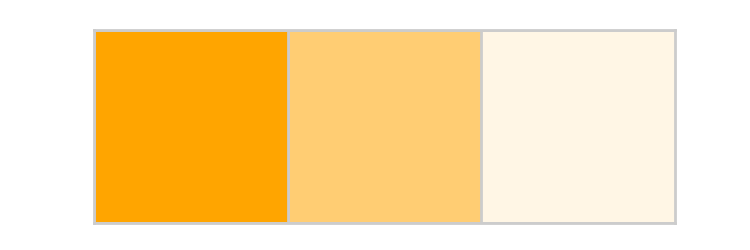

In [9]:
sns.set_style('whitegrid')
color=sns.light_palette("orange",3,reverse=True)
sns.palplot(color)

<IPython.core.display.Javascript object>


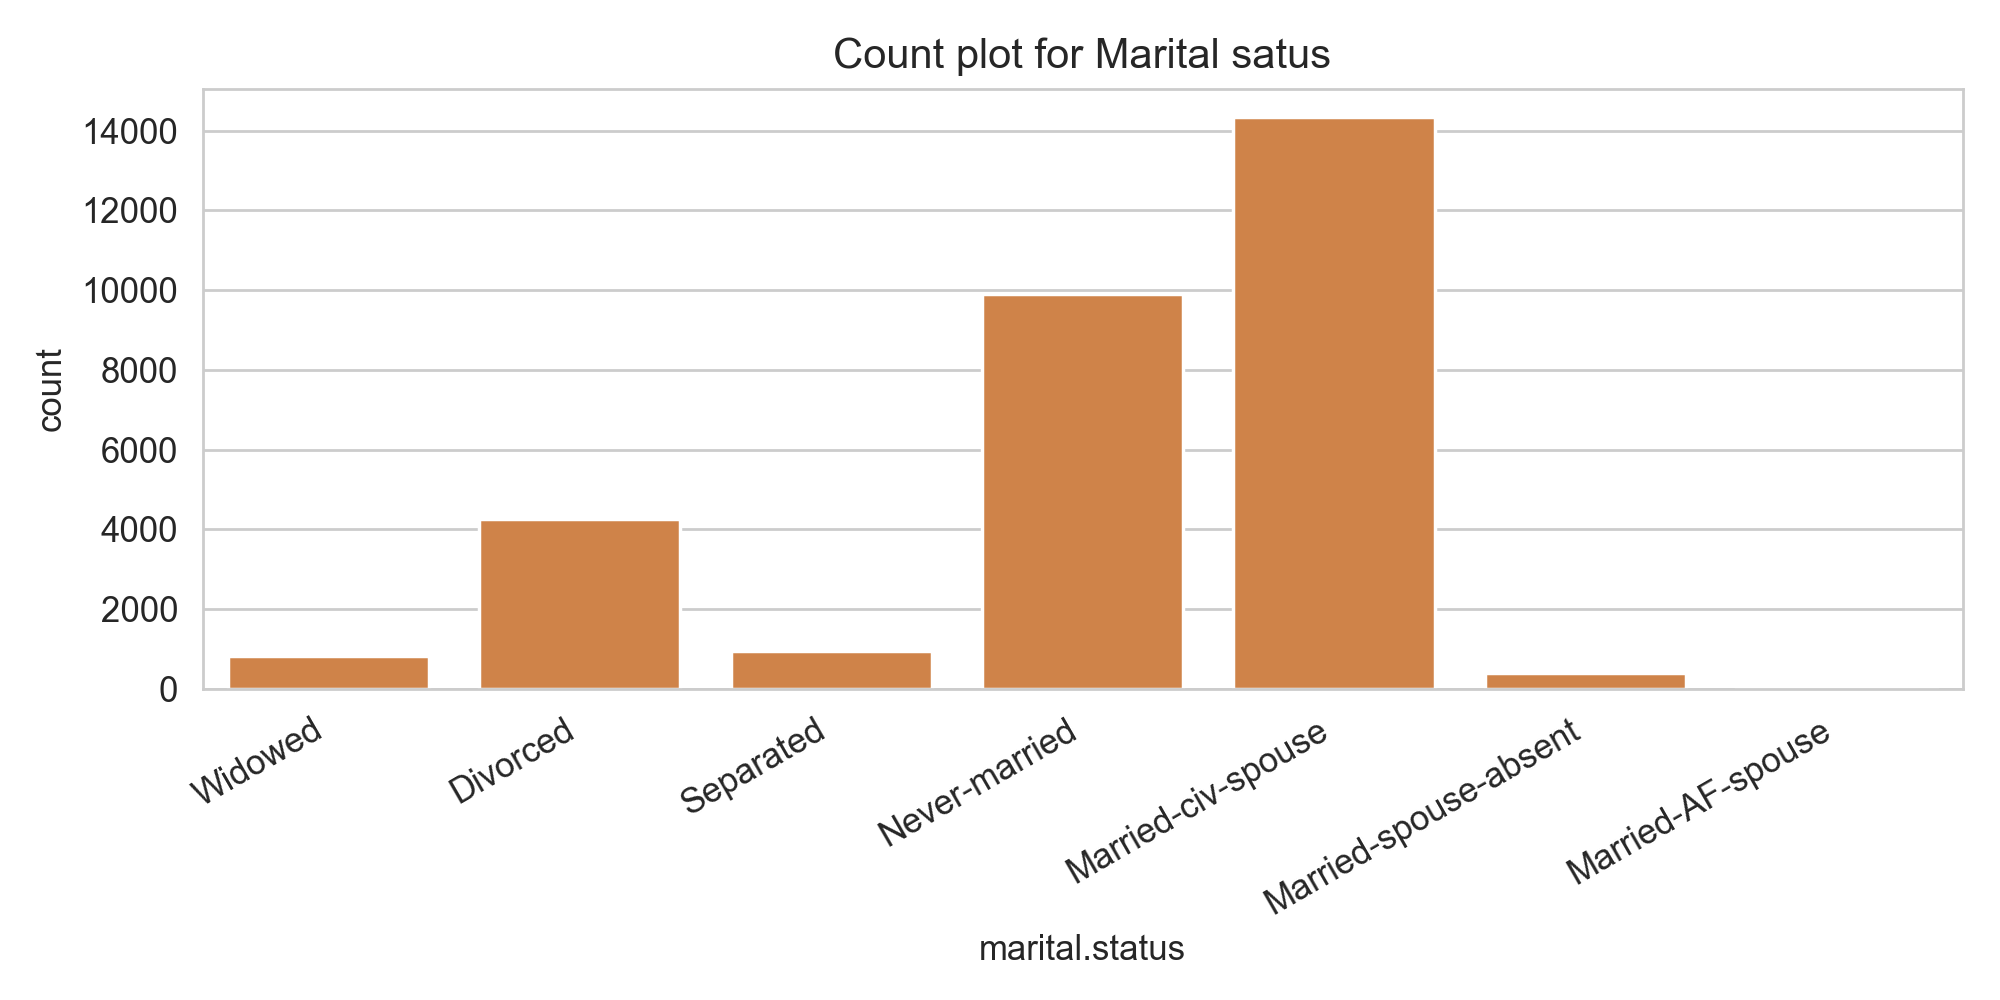

In [6]:
plt.figure(figsize=(8,4))
fig=sns.countplot(df['marital.status'],color=(0.9,0.5,0.2))
fig.set_xticklabels(fig.get_xticklabels(), rotation=30, ha="right")
fig.set_title('Count plot for Marital satus',fontsize=12)
plt.tight_layout()

In [7]:
def change_marital(x):
    if x=='Widowed' or x=='Divorced' or x=='Separated' or x=='Married-spouse-absent':
        return 'Separate'
    elif x=='Never-married':
        return 'Never married'
    else:
        return 'Married'
    
df['marital.status']=df['marital.status'].apply(change_marital)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Separate,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
3,54,Private,140359,7th-8th,4,Separate,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separate,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Separate,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separate,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K


<IPython.core.display.Javascript object>


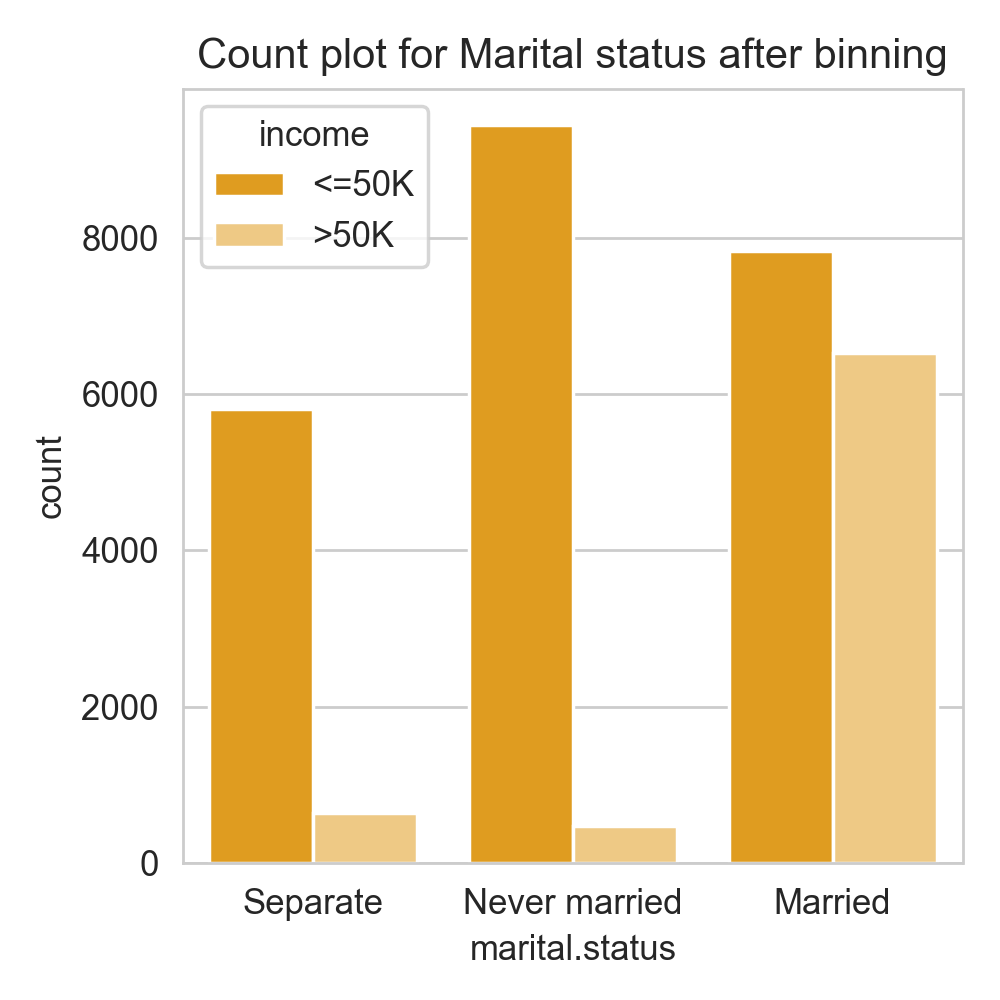

In [10]:
plt.figure(figsize=(4,4))
fig=sns.countplot(df['marital.status'],hue=df.income, palette=color)
fig.set_title('Count plot for Marital status after binning',fontsize=12)
plt.tight_layout()

### (3) education & education.num

범주를 16개에서 7개로 줄임: ①HS-under(Preschool, 1st-4th,5th-6th,7th-8th,9th,10th,11th,12th), ②HS-grad(HS-grad), ③College(Some-college), ④Associate(Assoc-voc, Assoc-acdm), ⑤Bachelor(Bachelors), ⑥Master(Masters, Prof-school), ⑦Doctorate(Doctorate) 

<IPython.core.display.Javascript object>


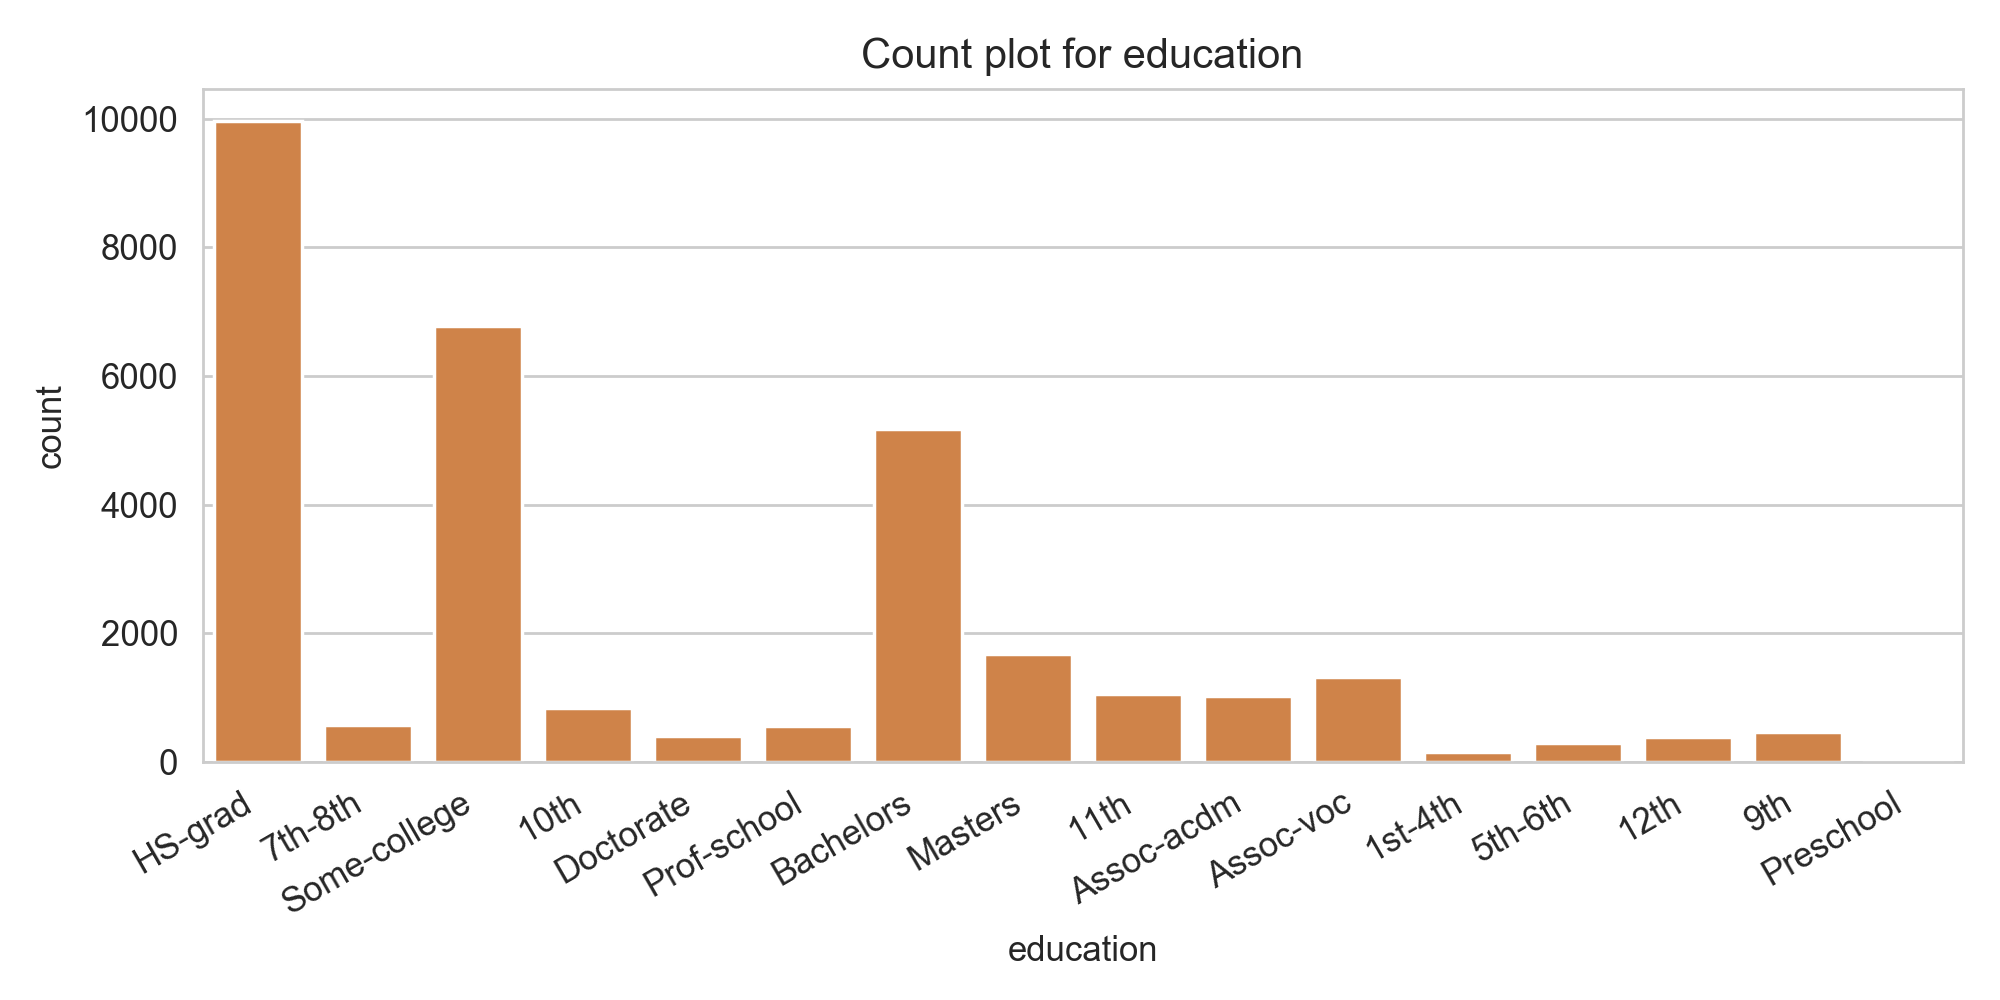

In [12]:
plt.figure(figsize=(8,4))
fig=sns.countplot(df['education'],color=(0.9,0.5,0.2))
fig.set_xticklabels(fig.get_xticklabels(), rotation=30, ha="right")
fig.set_title('Count plot for education',fontsize=12)
plt.tight_layout()

In [13]:
def change_edu(x):
    if x=='Preschool' or x=='1st-4th' or x=='5th-6th' or x=='7th-8th' or x=='9th' or x=='10th' or x=='11th' or x=='12th':
        return 'HS-under'
    elif x=='HS-grad':
        return 'HS-grad'
    elif x=='Some-college':
        return 'College'
    elif x=='Assoc-voc' or x=='Assoc-acdm':
        return 'Associate'
    elif x=='Bachelors':
        return 'Bachelor'
    elif x=='Masters' or x=='Prof-school':
        return 'Master'
    else:
        return 'Doctorate'

df['education']=df['education'].apply(change_edu)

In [14]:
def change_edunum(x):
    if x in list(range(1,9)):
        return 1
    elif x==9:
        return 2
    elif x==10:
        return 3
    elif x==11 or x==12:
        return 4
    elif x==13:
        return 5
    elif x==14 or x==15:
        return 6
    else:
        return 7
    
df['education.num']=df['education.num'].apply(change_edunum)

<IPython.core.display.Javascript object>


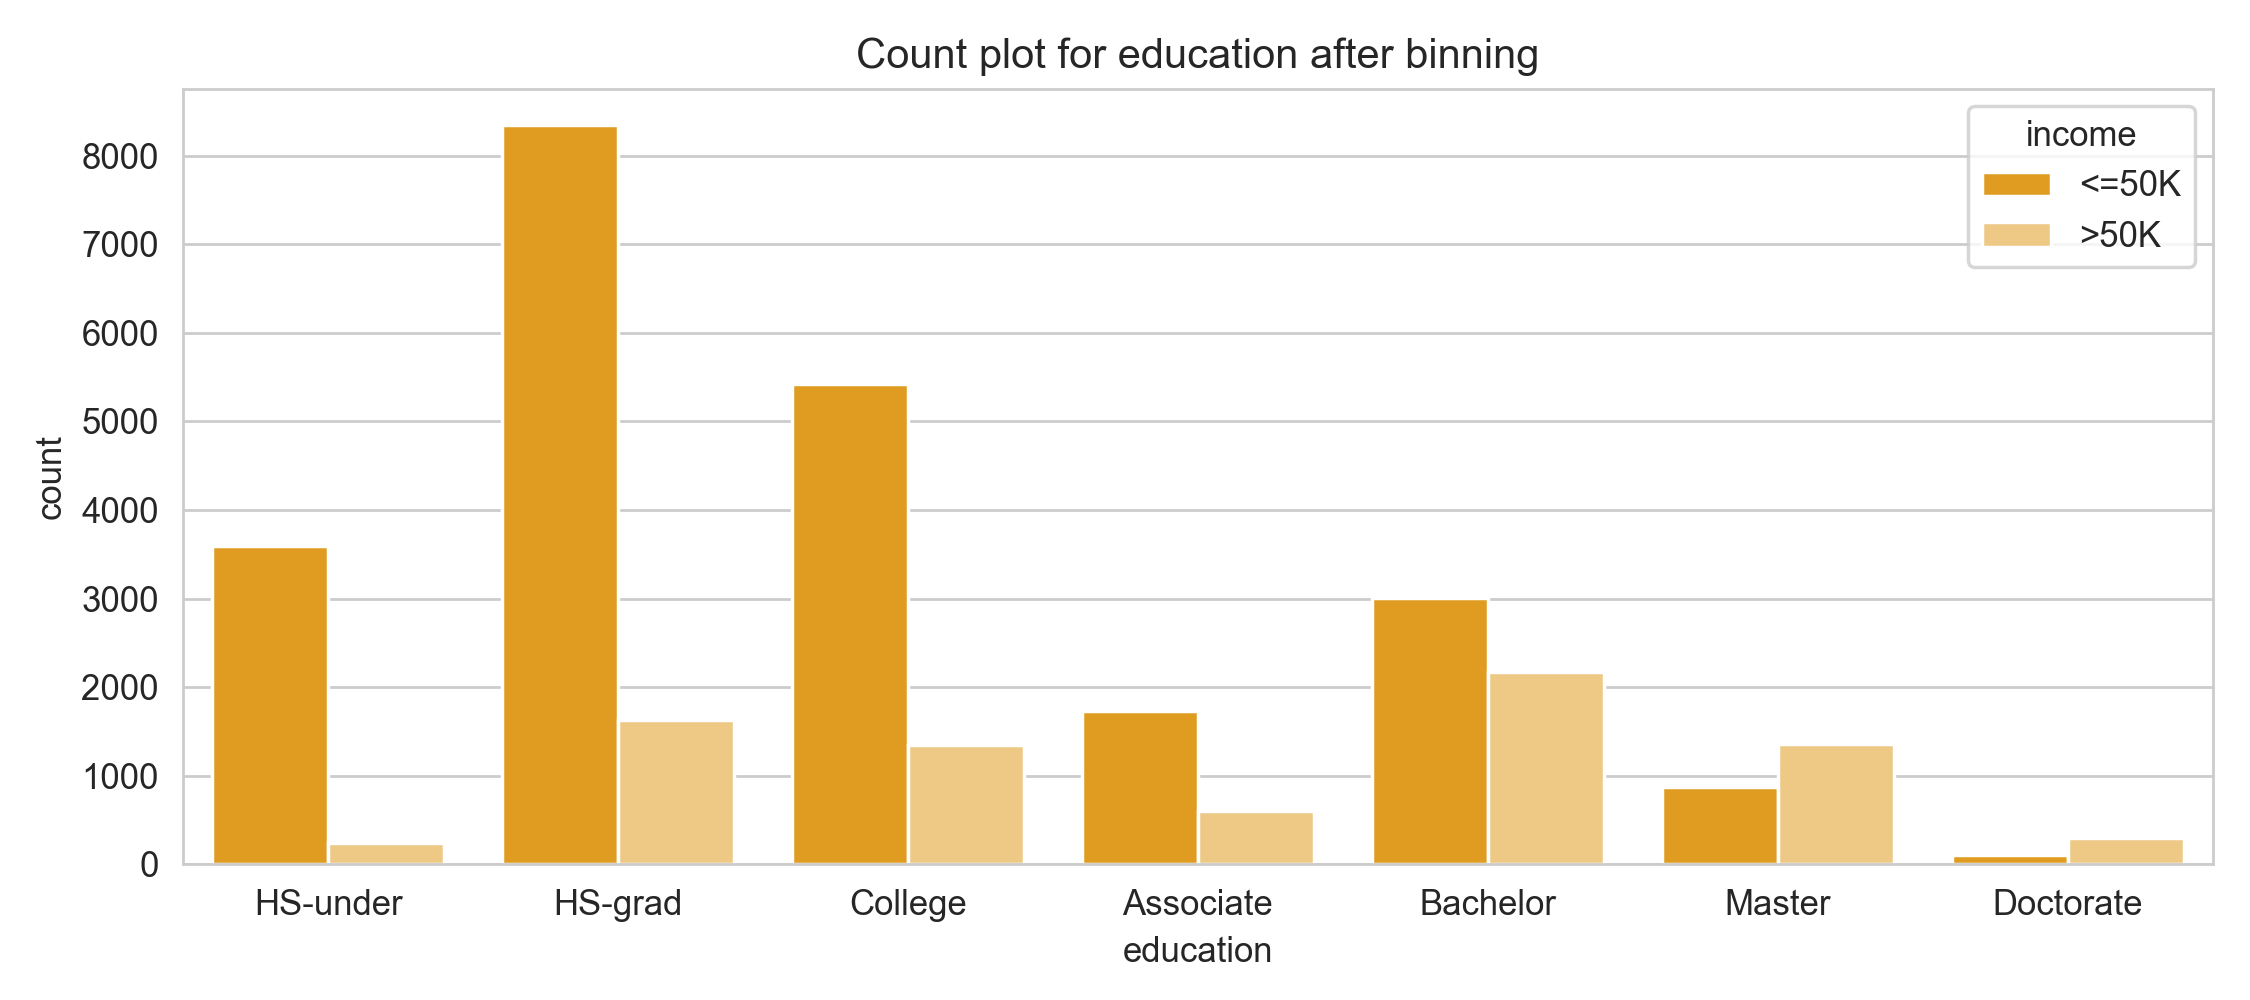

In [15]:
plt.figure(figsize=(9,4))
fig=sns.countplot(df['education'],hue=df.income,palette=color, 
                  order=['HS-under','HS-grad','College','Associate','Bachelor','Master','Doctorate'])
fig.set_title('Count plot for education after binning',fontsize=12)
plt.tight_layout()

## 2. 랜덤포레스트 적용 및 Feature Importance

In [23]:
y=df.income
X=df.drop(['income','fnlwgt','education'],axis=1)

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(y)
for i in ['workclass','marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']:
    X[i]=le.fit_transform(X[i])

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=123, stratify=y)

### (1) 과적합시킨 랜포

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rf = RandomForestClassifier(n_estimators=300, random_state=0).fit(X_train, y_train)
print('train set accuracy: ',metrics.accuracy_score(y_train, rf.predict(X_train)))
print('test set accuracy: ', metrics.accuracy_score(y_test, rf.predict(X_test)))

train set accuracy:  0.9793090621658065
test set accuracy:  0.8438923844651768


<IPython.core.display.Javascript object>


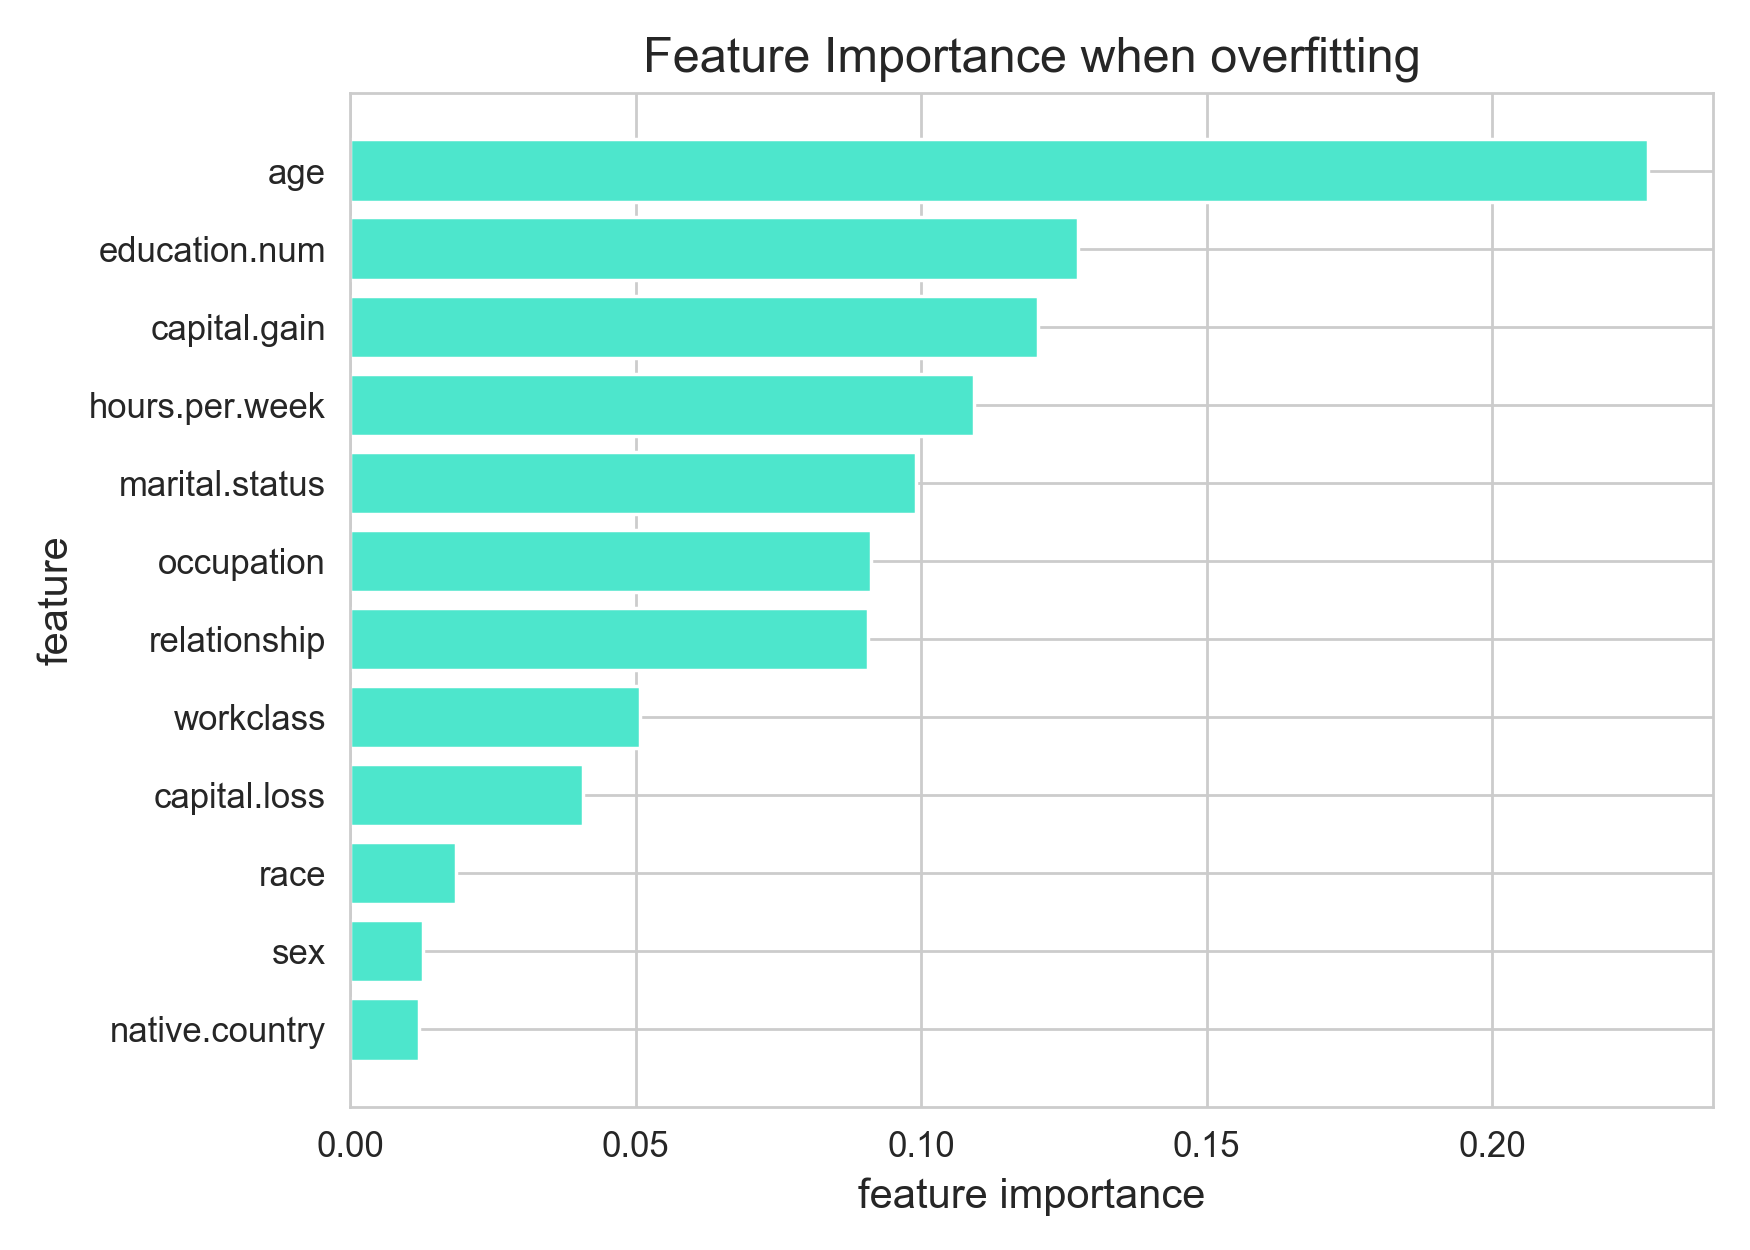

In [25]:
importance = pd.DataFrame(rf.feature_importances_, columns=['importance'])
importance.index = X_train.columns.tolist()
importance = importance.sort_values(by='importance')

plt.figure(figsize=(7,5))
plt.barh(importance.index, importance.importance, align='center', color=(0.3,0.9,0.8))
plt.xlabel('feature importance', size=12)
plt.ylabel('feature', size=12)
plt.title('Feature Importance when overfitting', size=14)
plt.tight_layout()

### (2) max-depth=15 설정 후 랜포

In [26]:
rf1 = RandomForestClassifier(n_estimators=300, random_state=0, max_depth=15).fit(X_train, y_train)
print('train set accuracy: ',metrics.accuracy_score(y_train, rf1.predict(X_train)))
print('test set accuracy: ', metrics.accuracy_score(y_test, rf1.predict(X_test)))

train set accuracy:  0.9086808945924583
test set accuracy:  0.8600564113690605


<IPython.core.display.Javascript object>


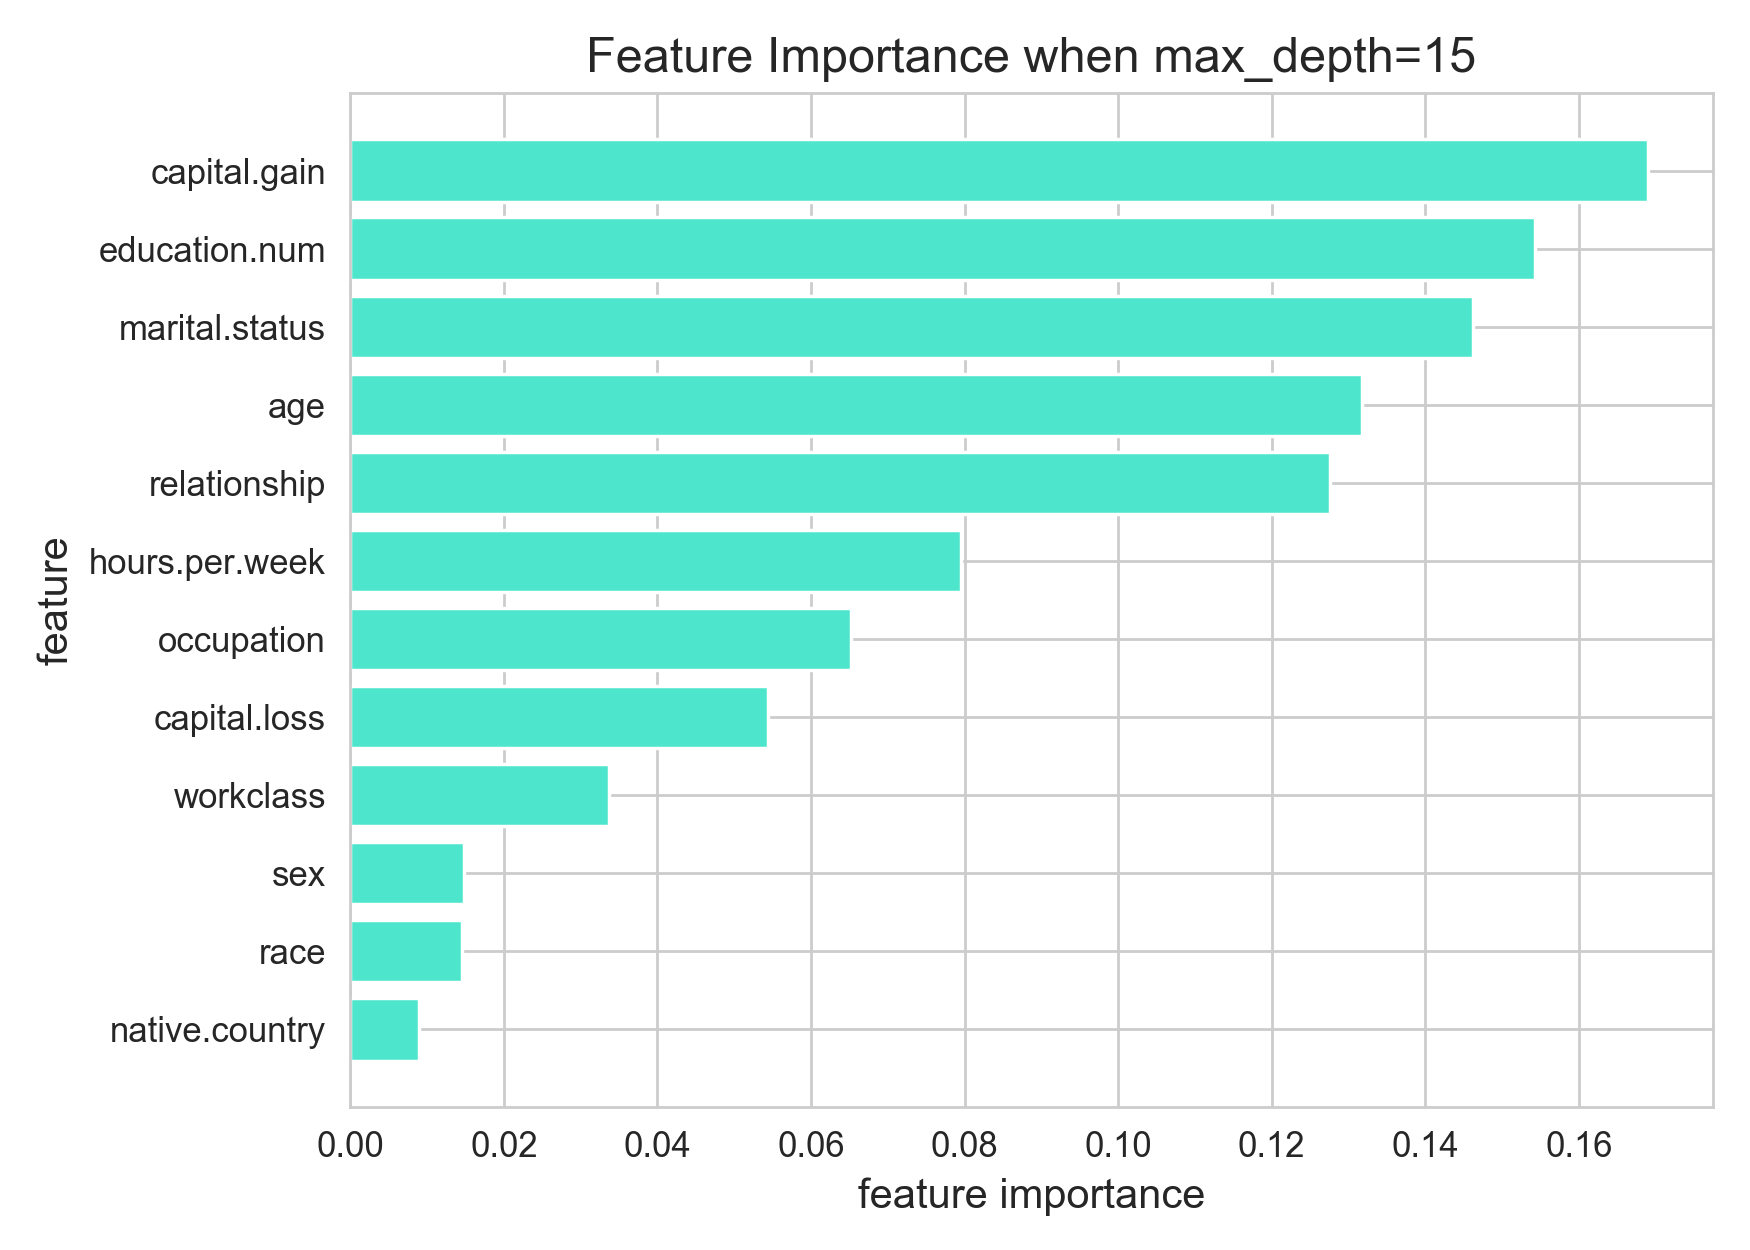

In [27]:
importance = pd.DataFrame(rf1.feature_importances_, columns=['importance'])
importance.index = X_train.columns.tolist()
importance = importance.sort_values(by='importance')

plt.figure(figsize=(7,5))
plt.barh(importance.index, importance.importance, align='center', color=(0.3,0.9,0.8))
plt.xlabel('feature importance', size=12)
plt.ylabel('feature', size=12)
plt.title('Feature Importance when max_depth=15', size=14)
plt.tight_layout()

### (3) max-depth=10 설정 후 랜포

In [28]:
rf2 = RandomForestClassifier(n_estimators=300, random_state=0, max_depth=10).fit(X_train, y_train)
print('train set accuracy: ',metrics.accuracy_score(y_train, rf2.predict(X_train)))
print('test set accuracy: ', metrics.accuracy_score(y_test, rf2.predict(X_test)))

train set accuracy:  0.8712512205328498
test set accuracy:  0.8568019093078759


<IPython.core.display.Javascript object>


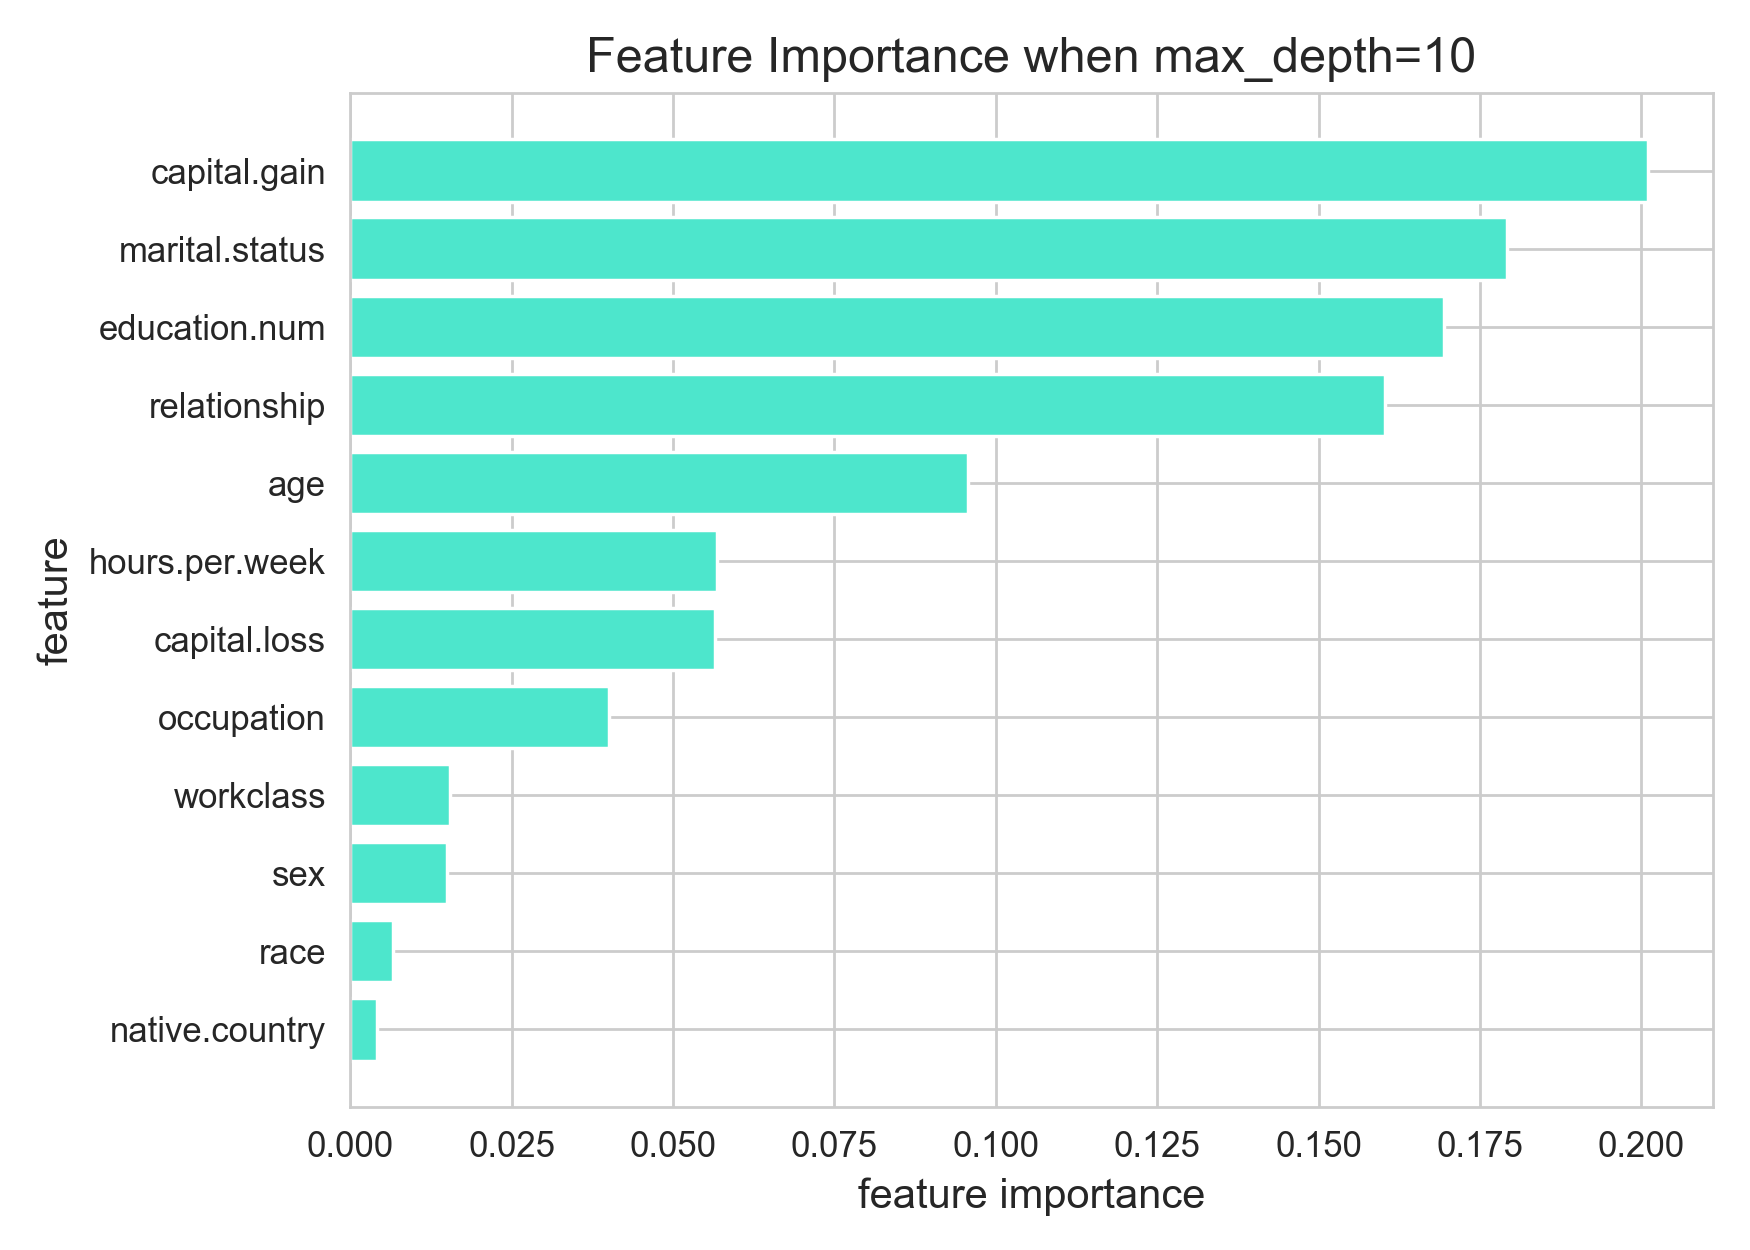

In [29]:
importance = pd.DataFrame(rf2.feature_importances_, columns=['importance'])
importance.index = X_train.columns.tolist()
importance = importance.sort_values(by='importance')

plt.figure(figsize=(7,5))
plt.barh(importance.index, importance.importance, align='center', color=(0.3,0.9,0.8))
plt.xlabel('feature importance', size=12)
plt.ylabel('feature', size=12)
plt.title('Feature Importance when max_depth=10', size=14)
plt.tight_layout()

### (4)  max-depth=6로 설정 후 랜포

In [32]:
rf3 = RandomForestClassifier(n_estimators=300, random_state=0, max_depth=6).fit(X_train, y_train)
print('train set accuracy: ',metrics.accuracy_score(y_train, rf3.predict(X_train)))
print('test set accuracy: ', metrics.accuracy_score(y_test, rf3.predict(X_test)))

train set accuracy:  0.853629051006649
test set accuracy:  0.8496420047732697


<IPython.core.display.Javascript object>


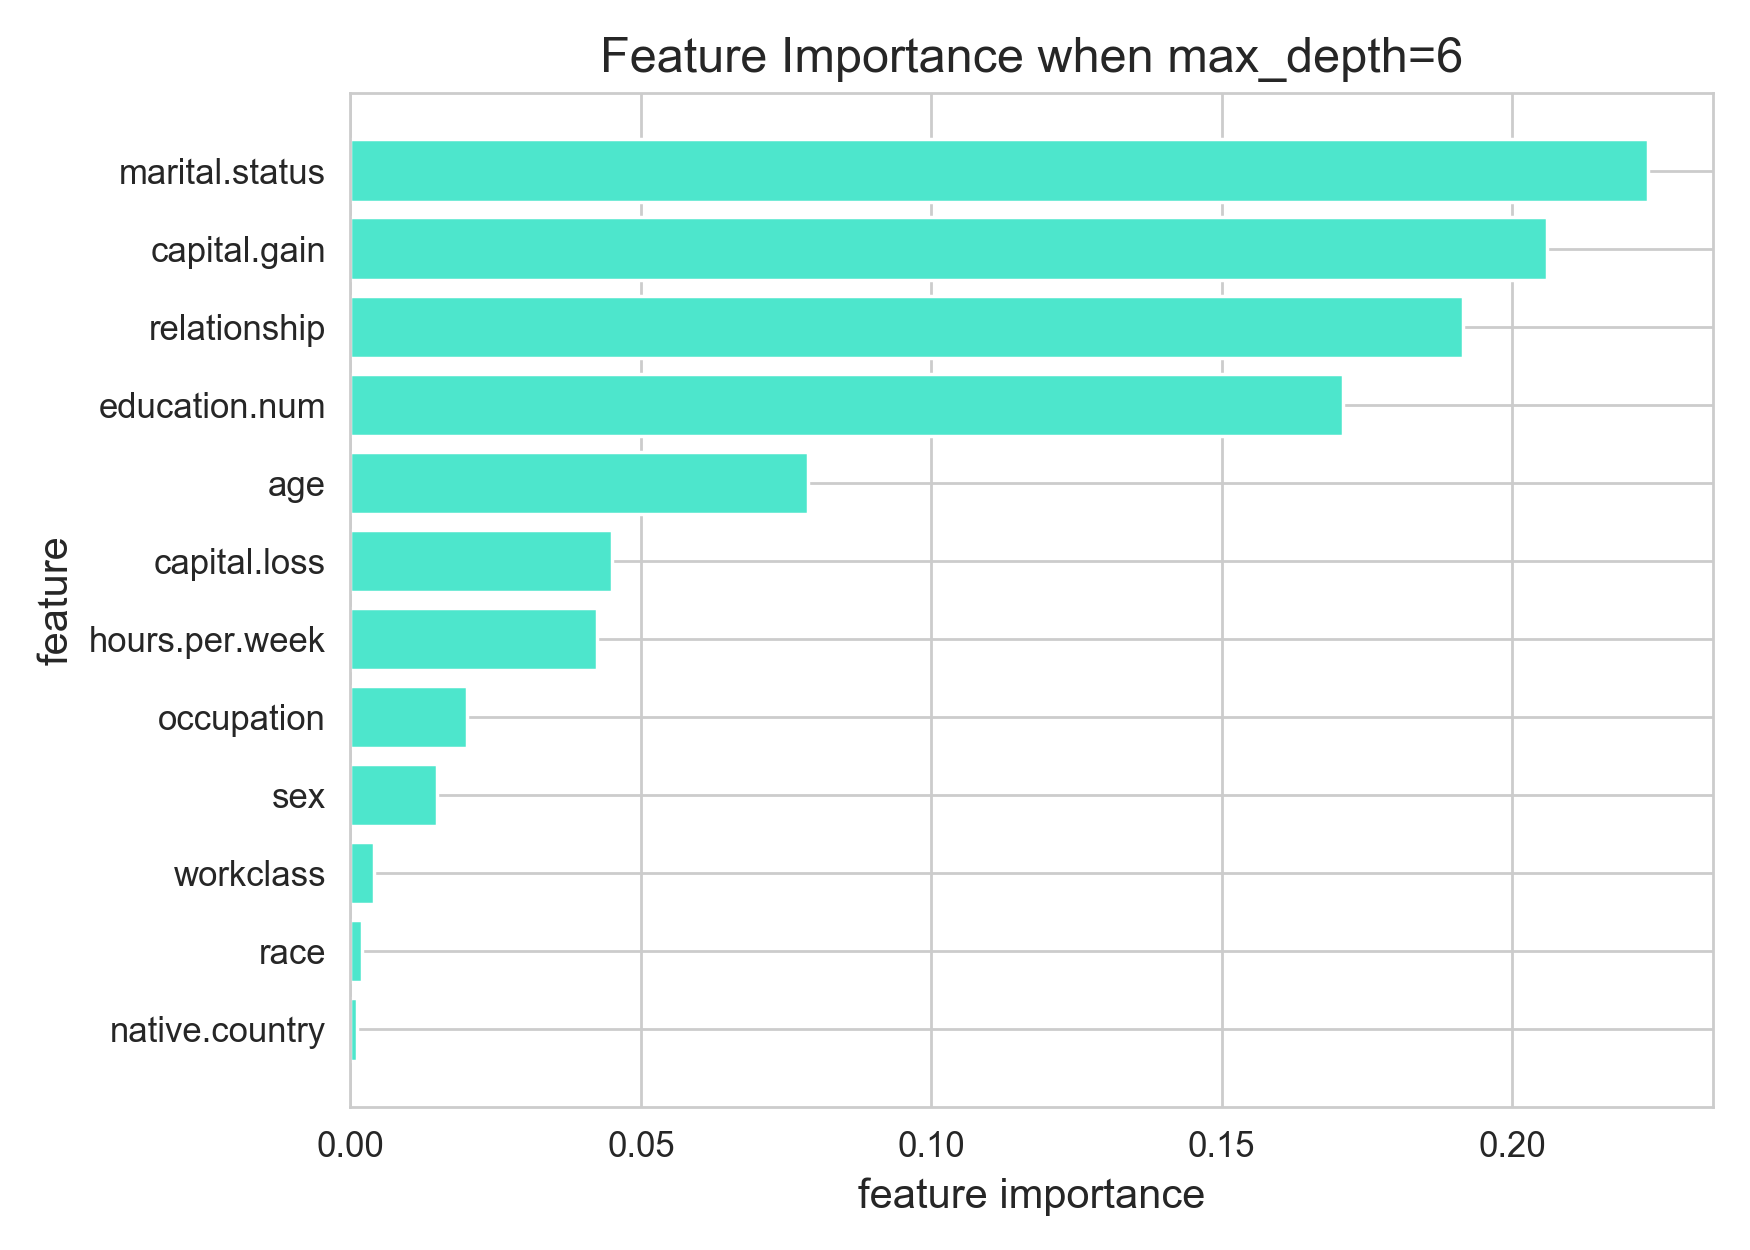

In [33]:
importance = pd.DataFrame(rf3.feature_importances_, columns=['importance'])
importance.index = X_train.columns.tolist()
importance = importance.sort_values(by='importance')

plt.figure(figsize=(7,5))
plt.barh(importance.index, importance.importance, align='center', color=(0.3,0.9,0.8))
plt.xlabel('feature importance', size=12)
plt.ylabel('feature', size=12)
plt.title('Feature Importance when max_depth=6', size=14)
plt.tight_layout()